# SVHN Dataset 

** Preprocessing the 32 x 32 image datset **

Pre-processing the 32-by-32 images from the SVHN dataset centered around a single digit. In this dataset all digits have been resized to a fixed resolution of 32-by-32 pixels. The original character bounding boxes are extended in the appropriate dimension to become square windows, so that resizing them to 32-by-32 pixels does not introduce aspect ratio distortions

In this notebook we apply the following preprocessing steps:


   * Create a Startified 13% of data in Validation Set
   * Converting the Label 10's to 0's
   * Greyscale conversion of image(data) for easy computation
   * Normalization of data 

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from skimage import color
from skimage import io
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0)

## Loading Data .....

` Reading the .MAT files`

In [28]:
def load_data(path):
    """ Helper function for loading a MAT-File"""
    data = loadmat(path)
    return data['X'], data['y']

X_train, y_train = load_data('train_32x32.mat')
X_test, y_test = load_data('test_32x32.mat')

print("Training Set", X_train.shape, y_train.shape)
print("Test Set", X_test.shape, y_test.shape)

('Training Set', (32, 32, 3, 73257), (73257, 1))
('Test Set', (32, 32, 3, 26032), (26032, 1))


**` Transposing the the train and test data
by converting it from  
(width, height, channels, size) -> (size, width, height, channels) `**

In [29]:
# Transpose the image arrays
X_train, y_train = X_train.transpose((3,0,1,2)), y_train[:,0]
X_test, y_test = X_test.transpose((3,0,1,2)), y_test[:,0]

print("Training Set", X_train.shape)
print("Test Set", X_test.shape)
print('')

# Calculate the total number of images
num_images = X_train.shape[0] + X_test.shape[0]

print("Total Number of Images", num_images)

('Training Set', (73257, 32, 32, 3))
('Test Set', (26032, 32, 32, 3))

('Total Number of Images', 99289)



` Plotting Function for fig in n rows X m columns 
can be used for grayscale and RGB both`

In [30]:
def plot_images(img, labels, nrows, ncols):
    """ Plot nrows x ncols images
    """
    fig, axes = plt.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flat): 
        if img[i].shape == (32, 32, 3):
            ax.imshow(img[i])
        else:
            ax.imshow(img[i,:,:,0])
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(labels[i])


Plot some of the training images

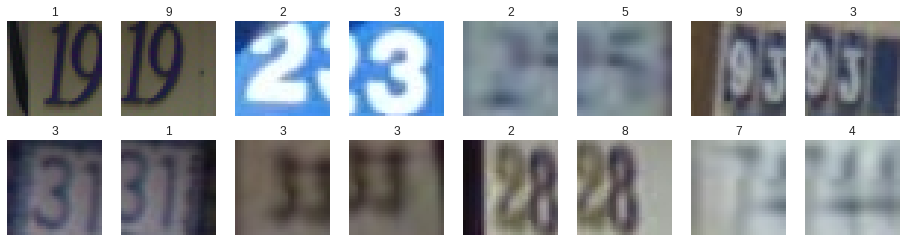

In [31]:
# Plot some training set images
plot_images(X_train, y_train, 2, 8)

Plot some of testing set images

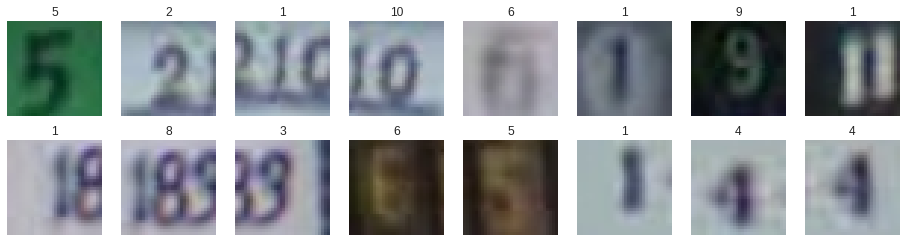

In [32]:
# Plot some test set images
plot_images(X_test, y_test, 2, 8)

#### To check unique labels

In [33]:
print(np.unique(y_train))

[ 1  2  3  4  5  6  7  8  9 10]


### Plotting Distribution of Data

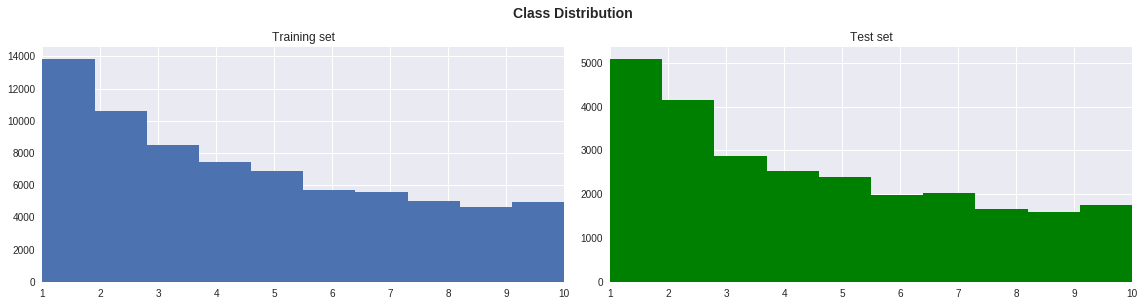

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

fig.suptitle('Class Distribution', fontsize=14, fontweight='bold', y=1.05)

ax1.hist(y_train, bins=10)
ax1.set_title("Training set")
ax1.set_xlim(1, 10)

ax2.hist(y_test, color='g', bins=10)
ax2.set_title("Test set")

fig.tight_layout()


All distributions have a positive skew, meaning that we have an underweight of higher values.

#### Converting Label 10 -> 0

In [35]:
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

In [36]:
print(np.unique(y_train))

[0 1 2 3 4 5 6 7 8 9]


### Splitting the Training to Train+Validation

`Splitting to 13% in Val Set as it gives around 9500 data
having min. of 800 instances of each class`

`Using random state to regenrate the whole Dataset in re-run`

In [37]:
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.13, random_state=7, stratify = y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.13, random_state=7)

#### Visualize New distribution

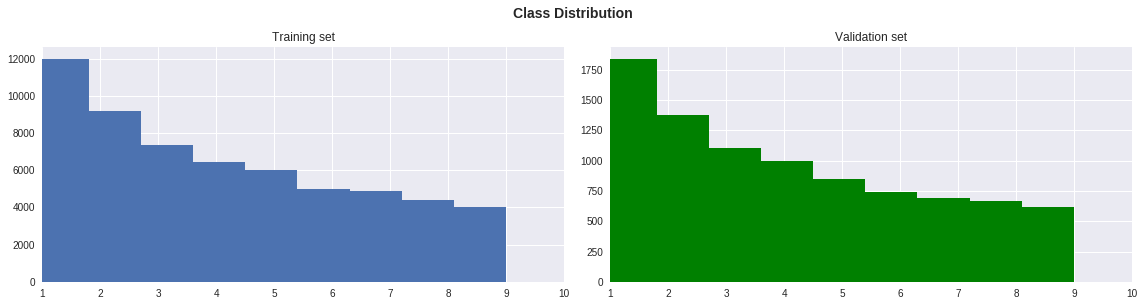

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

fig.suptitle('Class Distribution', fontsize=14, fontweight='bold', y=1.05)

ax1.hist(y_train, bins=10)
ax1.set_title("Training set")
ax1.set_xlim(1, 10)

ax2.hist(y_val, color='g', bins=10)
ax2.set_title("Validation set")

fig.tight_layout()


`Data in each Set`

In [39]:
y_train.shape, y_val.shape, y_test.shape

((63733,), (9524,), (26032,))


## Grayscale Conversion 

To speed up our experiments we will convert our images from RGB to Grayscale, which grately reduces the amount of data we will have to process. 

 ** Y = 0.2990R + 0.5870G + 0.1140B **

Here is a simple function that helps us print the size of a numpy array in a human readable format.


In [40]:
def rgb2gray(images):
    return np.expand_dims(np.dot(images, [0.2990, 0.5870, 0.1140]), axis=3)

`Converting to Float for numpy computation`

In [41]:
train_greyscale = rgb2gray(X_train).astype(np.float32)
test_greyscale = rgb2gray(X_test).astype(np.float32)
val_greyscale = rgb2gray(X_val).astype(np.float32)

In [42]:
print("Training Set", train_greyscale.shape)
print("Validation Set", val_greyscale.shape)
print("Test Set", test_greyscale.shape)
print('')


('Training Set', (63733, 32, 32, 1))
('Validation Set', (9524, 32, 32, 1))
('Test Set', (26032, 32, 32, 1))



` Removing RGB train, test, val set 
to reduce RAM Storage occupied by them`

In [43]:
del X_train, X_test, X_val

### Ploting the Grayscale Image

` Before Normalization`

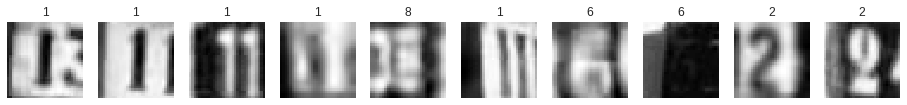

In [44]:
plot_images(train_greyscale, y_train, 1, 10)

### Normalization

After skimming some of the publications with the lowest error rate on the SVHN dataset, found different pre-processing techniques applied to the SVHN dataset.

    Liang et al. 2015 report that the pre-processed the images by removing the per-pixel mean value calculated over 
    the entire set.
    Goodfellow et al. 2013 report that they subtract the mean from every image.

Normalization refers to normalizing the data dimensions so that they are of approximately the same scale. 
Divide each dimension by its standard deviation, once it has been zero-centered. 

The following figure taken from the [CS231n notes](http://cs231n.github.io/neural-networks-2/) illutrates how this changes the data.

![normalized_img.png](http://cs231n.github.io/assets/nn2/prepro1.jpeg)

In [48]:
# Calculate the mean on the training data
train_mean = np.mean(train_greyscale, axis=0)

# Calculate the std on the training data
train_std = np.std(train_greyscale, axis=0)

# Subtract it equally from all splits
train_greyscale_norm = (train_greyscale - train_mean) / train_std
test_greyscale_norm = (test_greyscale - train_mean)  / train_std
val_greyscale_norm = (val_greyscale - train_mean) / train_std

`Plotting After Normalization`

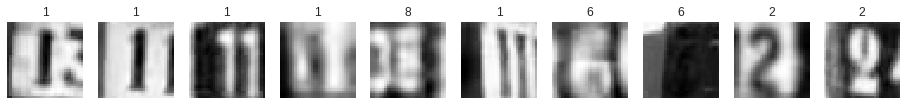

In [50]:
plot_images(train_greyscale_norm, y_train, 1, 10)

### One Hot Label Encoding

`Apply One Hot Encoding to make label
suitable for CNN Classification`

In [51]:
from sklearn.preprocessing import OneHotEncoder
 
# Fit the OneHotEncoder
enc = OneHotEncoder().fit(y_train.reshape(-1, 1))

# Transform the label values to a one-hot-encoding scheme
y_train = enc.transform(y_train.reshape(-1, 1)).toarray()
y_test = enc.transform(y_test.reshape(-1, 1)).toarray()
y_val = enc.transform(y_val.reshape(-1, 1)).toarray()

print("Training set", y_train.shape)
print("Validation set", y_val.shape)
print("Test set", y_test.shape)

('Training set', (63733, 10))
('Validation set', (9524, 10))
('Test set', (26032, 10))


## Storing Data to Disk

`Stored only the Grayscale Data 
not the RGB `

In [53]:
import h5py

# Create file
h5f = h5py.File('SVHN_grey.h5', 'w')

# Store the datasets
h5f.create_dataset('X_train', data=train_greyscale_norm)
h5f.create_dataset('y_train', data=y_train)
h5f.create_dataset('X_test', data=test_greyscale_norm)
h5f.create_dataset('y_test', data=y_test)
h5f.create_dataset('X_val', data=val_greyscale_norm)
h5f.create_dataset('y_val', data=y_val)

# Close the file
h5f.close()